In [24]:
import sys
sys.path.append(r"D:\I3D\pytorch-i3d")
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from pytorch_i3d import InceptionI3d
from tqdm import tqdm
from collections import Counter

# -------------------------------
# CUSTOM PRINT
# -------------------------------
def custom_print(msg):
    sys.stdout.write(msg + "\n")
    sys.stdout.flush()

# -------------------------------
# CONFIG
# -------------------------------
dataset_path = r"D:\I3D\yashtidataset"
save_model_path = r"D:\I3D\MODEL\i3d_trained.pt"
batch_size = 4
max_epochs = 50
learning_rate = 1e-4
patience = 10  # Early stopping patience
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_print(f"Using device: {device}")

# -------------------------------
# CUSTOM DATASET
# -------------------------------
class VideoClipDataset(Dataset):
    def __init__(self, data_root):
        self.clip_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(data_root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}

        custom_print(f"📁 Found classes: {self.class_names}")

        # Load all .pt clips
        for cls in self.class_names:
            folder = os.path.join(data_root, cls)
            for f in os.listdir(folder):
                if f.endswith(".pt"):
                    self.clip_paths.append(os.path.join(folder, f))
                    self.labels.append(self.class_to_idx[cls])

        # Handle class imbalance
        label_counts = Counter(self.labels)
        total = len(self.labels)
        num_classes = len(label_counts)

        # Compute class weights inversely proportional to frequency
        self.class_weights = {cls: total / (num_classes * count) for cls, count in label_counts.items()}
        # Assign sample weight for each instance
        self.sample_weights = [self.class_weights[label] for label in self.labels]

        custom_print(f"⚖️ Class balance: {dict(label_counts)}")
        custom_print(f"🧮 Computed class weights: {self.class_weights}")

    def __len__(self):
        return len(self.clip_paths)

    def __getitem__(self, idx):
        clip = torch.load(self.clip_paths[idx], map_location="cpu").float()
        label = self.labels[idx]
        return clip, label

    def get_sampler(self):
        """Return a WeightedRandomSampler to handle class imbalance"""
        return WeightedRandomSampler(
            weights=self.sample_weights,
            num_samples=len(self.sample_weights),
            replacement=True
        )


Using device: cuda


In [25]:

# -------------------------------
# LOAD DATA
# -------------------------------
train_dataset = VideoClipDataset(dataset_path)
sampler = train_dataset.get_sampler()
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
num_classes = len(train_dataset.class_names)
custom_print(f"Total clips: {len(train_dataset)} | Classes: {num_classes}")
custom_print("⚖️ Using WeightedRandomSampler to handle class imbalance")

# -------------------------------
# MODEL SETUP
# -------------------------------
i3d = InceptionI3d(400, in_channels=32)
i3d.replace_logits(num_classes)
i3d.avg_pool = nn.AvgPool3d(kernel_size=(1, 7, 7), stride=1)
i3d = i3d.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(i3d.parameters(), lr=learning_rate)

📁 Found classes: ['person', 'snatcher', 'victim']
⚖️ Class balance: {0: 791, 1: 297, 2: 425}
🧮 Computed class weights: {0: 0.6375895490939739, 1: 1.6980920314253647, 2: 1.1866666666666668}
Total clips: 1513 | Classes: 3
⚖️ Using WeightedRandomSampler to handle class imbalance


In [26]:
# -------------------------------
# TRAIN LOOP (early stopping + best model)
# -------------------------------
custom_print("🚀 Starting training with early stopping...")

max_epochs = 50          # maximum number of epochs
patience = 10           # stop if loss doesn't improve for 'patience' epochs
best_acc = 0.0
epochs_no_improve = 0

for epoch in range(max_epochs):
    i3d.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{max_epochs}]", ncols=90)
    for clips, labels in progress_bar:
        clips, labels = clips.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = i3d(clips).squeeze(-1).squeeze(-1).squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / len(train_loader)
    acc = 100 * correct / total
    custom_print(f"Epoch [{epoch+1}/{max_epochs}] | Avg Loss: {avg_loss:.4f} | Accuracy: {acc:.2f}%")

    # Early stopping based on accuracy
    if acc > best_acc:
        best_acc = acc
        epochs_no_improve = 0
        torch.save(i3d.state_dict(), save_model_path)
        custom_print(f"💾 Best model updated (Epoch {epoch+1}) with accuracy {acc:.2f}%")
    else:
        epochs_no_improve += 1
        custom_print(f"⚠️ No improvement in accuracy for {epochs_no_improve}/{patience} epochs")

    if epochs_no_improve >= patience:
        custom_print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
        break

custom_print(f"✅ Training complete. Best model saved at: {save_model_path} | Best Accuracy: {best_acc:.2f}%")


🚀 Starting training with early stopping...


Epoch [1/50]: 100%|████████████████████████| 379/379 [00:58<00:00,  6.48it/s, Loss=0.7859]

Epoch [1/50] | Avg Loss: 1.1337 | Accuracy: 36.75%
💾 Best model updated (Epoch 1) with accuracy 36.75%



Epoch [2/50]: 100%|████████████████████████| 379/379 [00:56<00:00,  6.71it/s, Loss=1.1117]

Epoch [2/50] | Avg Loss: 1.1129 | Accuracy: 38.40%
💾 Best model updated (Epoch 2) with accuracy 38.40%



Epoch [3/50]: 100%|████████████████████████| 379/379 [00:56<00:00,  6.67it/s, Loss=1.0430]

Epoch [3/50] | Avg Loss: 1.1028 | Accuracy: 39.92%
💾 Best model updated (Epoch 3) with accuracy 39.92%



Epoch [4/50]: 100%|████████████████████████| 379/379 [00:56<00:00,  6.69it/s, Loss=1.1897]

Epoch [4/50] | Avg Loss: 1.0963 | Accuracy: 39.99%
💾 Best model updated (Epoch 4) with accuracy 39.99%



Epoch [5/50]: 100%|████████████████████████| 379/379 [00:56<00:00,  6.68it/s, Loss=1.0824]

Epoch [5/50] | Avg Loss: 1.0813 | Accuracy: 41.51%


💾 Best model updated (Epoch 5) with accuracy 41.51%


Epoch [6/50]: 100%|████████████████████████| 379/379 [00:57<00:00,  6.57it/s, Loss=1.3551]

Epoch [6/50] | Avg Loss: 1.0846 | Accuracy: 40.85%
⚠️ No improvement in accuracy for 1/10 epochs



Epoch [7/50]: 100%|████████████████████████| 379/379 [00:56<00:00,  6.71it/s, Loss=0.9113]

Epoch [7/50] | Avg Loss: 1.0746 | Accuracy: 43.49%
💾 Best model updated (Epoch 7) with accuracy 43.49%



Epoch [8/50]: 100%|████████████████████████| 379/379 [00:56<00:00,  6.68it/s, Loss=1.3453]

Epoch [8/50] | Avg Loss: 1.0646 | Accuracy: 44.68%
💾 Best model updated (Epoch 8) with accuracy 44.68%



Epoch [9/50]: 100%|████████████████████████| 379/379 [00:56<00:00,  6.74it/s, Loss=1.0573]

Epoch [9/50] | Avg Loss: 1.0511 | Accuracy: 44.88%
💾 Best model updated (Epoch 9) with accuracy 44.88%



Epoch [10/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.76it/s, Loss=1.1360]

Epoch [10/50] | Avg Loss: 1.0797 | Accuracy: 42.76%
⚠️ No improvement in accuracy for 1/10 epochs



Epoch [11/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.77it/s, Loss=1.3897]

Epoch [11/50] | Avg Loss: 1.0742 | Accuracy: 43.82%
⚠️ No improvement in accuracy for 2/10 epochs



Epoch [12/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.68it/s, Loss=1.0358]

Epoch [12/50] | Avg Loss: 1.0494 | Accuracy: 46.73%
💾 Best model updated (Epoch 12) with accuracy 46.73%



Epoch [13/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.75it/s, Loss=1.0122]

Epoch [13/50] | Avg Loss: 1.0278 | Accuracy: 48.12%


💾 Best model updated (Epoch 13) with accuracy 48.12%


Epoch [14/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.73it/s, Loss=1.2605]

Epoch [14/50] | Avg Loss: 1.0646 | Accuracy: 43.56%
⚠️ No improvement in accuracy for 1/10 epochs



Epoch [15/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.70it/s, Loss=1.0191]

Epoch [15/50] | Avg Loss: 1.0298 | Accuracy: 45.34%
⚠️ No improvement in accuracy for 2/10 epochs



Epoch [16/50]: 100%|███████████████████████| 379/379 [00:55<00:00,  6.83it/s, Loss=1.0947]

Epoch [16/50] | Avg Loss: 1.0222 | Accuracy: 48.18%
💾 Best model updated (Epoch 16) with accuracy 48.18%



Epoch [17/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.72it/s, Loss=1.1908]

Epoch [17/50] | Avg Loss: 1.0146 | Accuracy: 49.11%


💾 Best model updated (Epoch 17) with accuracy 49.11%


Epoch [18/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.69it/s, Loss=1.1138]

Epoch [18/50] | Avg Loss: 1.0019 | Accuracy: 50.69%
💾 Best model updated (Epoch 18) with accuracy 50.69%



Epoch [19/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.72it/s, Loss=1.3191]

Epoch [19/50] | Avg Loss: 0.9900 | Accuracy: 51.42%
💾 Best model updated (Epoch 19) with accuracy 51.42%



Epoch [20/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.72it/s, Loss=1.0425]

Epoch [20/50] | Avg Loss: 0.9862 | Accuracy: 52.28%
💾 Best model updated (Epoch 20) with accuracy 52.28%



Epoch [21/50]: 100%|███████████████████████| 379/379 [00:55<00:00,  6.79it/s, Loss=1.2459]

Epoch [21/50] | Avg Loss: 1.0020 | Accuracy: 50.23%
⚠️ No improvement in accuracy for 1/10 epochs



Epoch [22/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.72it/s, Loss=1.0137]

Epoch [22/50] | Avg Loss: 0.9687 | Accuracy: 52.48%
💾 Best model updated (Epoch 22) with accuracy 52.48%



Epoch [23/50]: 100%|███████████████████████| 379/379 [00:55<00:00,  6.78it/s, Loss=1.1642]

Epoch [23/50] | Avg Loss: 0.9267 | Accuracy: 56.51%
💾 Best model updated (Epoch 23) with accuracy 56.51%



Epoch [24/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.77it/s, Loss=0.7891]

Epoch [24/50] | Avg Loss: 0.9430 | Accuracy: 56.84%
💾 Best model updated (Epoch 24) with accuracy 56.84%



Epoch [25/50]: 100%|███████████████████████| 379/379 [00:57<00:00,  6.59it/s, Loss=0.8867]

Epoch [25/50] | Avg Loss: 0.9113 | Accuracy: 57.83%
💾 Best model updated (Epoch 25) with accuracy 57.83%



Epoch [26/50]: 100%|███████████████████████| 379/379 [00:55<00:00,  6.81it/s, Loss=1.1503]

Epoch [26/50] | Avg Loss: 0.8926 | Accuracy: 59.42%
💾 Best model updated (Epoch 26) with accuracy 59.42%



Epoch [27/50]: 100%|███████████████████████| 379/379 [00:55<00:00,  6.78it/s, Loss=0.9772]

Epoch [27/50] | Avg Loss: 0.8784 | Accuracy: 61.80%
💾 Best model updated (Epoch 27) with accuracy 61.80%



Epoch [28/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.71it/s, Loss=1.2557]

Epoch [28/50] | Avg Loss: 0.8559 | Accuracy: 61.20%
⚠️ No improvement in accuracy for 1/10 epochs



Epoch [29/50]: 100%|███████████████████████| 379/379 [01:02<00:00,  6.04it/s, Loss=1.2166]

Epoch [29/50] | Avg Loss: 0.8203 | Accuracy: 64.51%


💾 Best model updated (Epoch 29) with accuracy 64.51%


Epoch [30/50]: 100%|███████████████████████| 379/379 [01:02<00:00,  6.05it/s, Loss=1.6223]

Epoch [30/50] | Avg Loss: 0.8252 | Accuracy: 63.71%
⚠️ No improvement in accuracy for 1/10 epochs



Epoch [31/50]: 100%|███████████████████████| 379/379 [01:03<00:00,  5.98it/s, Loss=1.0246]

Epoch [31/50] | Avg Loss: 0.7784 | Accuracy: 66.29%
💾 Best model updated (Epoch 31) with accuracy 66.29%



Epoch [32/50]: 100%|███████████████████████| 379/379 [01:03<00:00,  5.92it/s, Loss=0.8795]

Epoch [32/50] | Avg Loss: 0.7866 | Accuracy: 65.90%
⚠️ No improvement in accuracy for 1/10 epochs



Epoch [33/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.74it/s, Loss=1.6524]

Epoch [33/50] | Avg Loss: 0.7500 | Accuracy: 68.94%
💾 Best model updated (Epoch 33) with accuracy 68.94%



Epoch [34/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.69it/s, Loss=0.9297]

Epoch [34/50] | Avg Loss: 0.7193 | Accuracy: 68.61%
⚠️ No improvement in accuracy for 1/10 epochs



Epoch [35/50]: 100%|███████████████████████| 379/379 [00:55<00:00,  6.78it/s, Loss=0.7040]

Epoch [35/50] | Avg Loss: 0.6921 | Accuracy: 72.24%
💾 Best model updated (Epoch 35) with accuracy 72.24%



Epoch [36/50]: 100%|███████████████████████| 379/379 [00:56<00:00,  6.77it/s, Loss=1.0579]

Epoch [36/50] | Avg Loss: 0.6913 | Accuracy: 69.60%
⚠️ No improvement in accuracy for 1/10 epochs



Epoch [37/50]: 100%|███████████████████████| 379/379 [01:05<00:00,  5.80it/s, Loss=0.9222]

Epoch [37/50] | Avg Loss: 0.6884 | Accuracy: 71.05%
⚠️ No improvement in accuracy for 2/10 epochs



Epoch [38/50]: 100%|███████████████████████| 379/379 [01:11<00:00,  5.28it/s, Loss=1.1200]

Epoch [38/50] | Avg Loss: 0.6039 | Accuracy: 75.48%
💾 Best model updated (Epoch 38) with accuracy 75.48%



Epoch [39/50]: 100%|███████████████████████| 379/379 [01:02<00:00,  6.07it/s, Loss=1.0093]

Epoch [39/50] | Avg Loss: 0.5987 | Accuracy: 75.81%


💾 Best model updated (Epoch 39) with accuracy 75.81%


Epoch [40/50]: 100%|███████████████████████| 379/379 [00:59<00:00,  6.36it/s, Loss=1.8846]

Epoch [40/50] | Avg Loss: 0.5992 | Accuracy: 75.68%
⚠️ No improvement in accuracy for 1/10 epochs



Epoch [41/50]: 100%|███████████████████████| 379/379 [00:59<00:00,  6.41it/s, Loss=0.7007]

Epoch [41/50] | Avg Loss: 0.5708 | Accuracy: 77.00%
💾 Best model updated (Epoch 41) with accuracy 77.00%



Epoch [42/50]: 100%|███████████████████████| 379/379 [00:58<00:00,  6.52it/s, Loss=0.7608]

Epoch [42/50] | Avg Loss: 0.5697 | Accuracy: 77.99%
💾 Best model updated (Epoch 42) with accuracy 77.99%



Epoch [43/50]: 100%|███████████████████████| 379/379 [00:58<00:00,  6.50it/s, Loss=0.7355]

Epoch [43/50] | Avg Loss: 0.5303 | Accuracy: 79.64%


💾 Best model updated (Epoch 43) with accuracy 79.64%


Epoch [44/50]: 100%|███████████████████████| 379/379 [00:57<00:00,  6.56it/s, Loss=0.7237]

Epoch [44/50] | Avg Loss: 0.5021 | Accuracy: 80.30%
💾 Best model updated (Epoch 44) with accuracy 80.30%



Epoch [45/50]: 100%|███████████████████████| 379/379 [00:58<00:00,  6.50it/s, Loss=0.9568]

Epoch [45/50] | Avg Loss: 0.4739 | Accuracy: 81.69%
💾 Best model updated (Epoch 45) with accuracy 81.69%



Epoch [46/50]: 100%|███████████████████████| 379/379 [00:57<00:00,  6.55it/s, Loss=0.7841]

Epoch [46/50] | Avg Loss: 0.4731 | Accuracy: 81.89%
💾 Best model updated (Epoch 46) with accuracy 81.89%



Epoch [47/50]: 100%|███████████████████████| 379/379 [00:59<00:00,  6.40it/s, Loss=0.5066]

Epoch [47/50] | Avg Loss: 0.4837 | Accuracy: 80.77%
⚠️ No improvement in accuracy for 1/10 epochs



Epoch [48/50]: 100%|███████████████████████| 379/379 [00:59<00:00,  6.40it/s, Loss=0.9269]

Epoch [48/50] | Avg Loss: 0.4573 | Accuracy: 81.63%
⚠️ No improvement in accuracy for 2/10 epochs



Epoch [49/50]: 100%|███████████████████████| 379/379 [00:57<00:00,  6.58it/s, Loss=1.0519]

Epoch [49/50] | Avg Loss: 0.4385 | Accuracy: 83.74%
💾 Best model updated (Epoch 49) with accuracy 83.74%



Epoch [50/50]: 100%|███████████████████████| 379/379 [01:03<00:00,  5.94it/s, Loss=0.5989]

Epoch [50/50] | Avg Loss: 0.3904 | Accuracy: 84.93%


💾 Best model updated (Epoch 50) with accuracy 84.93%
✅ Training complete. Best model saved at: D:\I3D\MODEL\i3d_trained.pt | Best Accuracy: 84.93%


FINE TUNED BEST1

In [37]:
import sys
sys.path.append(r"D:\I3D\pytorch-i3d")
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
import random
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from pytorch_i3d import InceptionI3d
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# CUSTOM PRINT
# -------------------------------
def custom_print(msg):
    sys.stdout.write(msg + "\n")
    sys.stdout.flush()

# -------------------------------
# CONFIG
# -------------------------------
train_path = r"D:\I3D\yashtidataset"
test_path = r"D:\I3D\yashti_test\Merged dataset"
pretrained_model_path = r"D:\I3D\MODEL\best1.pt"
fine_tuned_model_path = r"D:\I3D\MODEL\i3d_finetuned.pt"

batch_size = 4
learning_rate = 1e-4
max_epochs = 50
patience = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_print(f"Using device: {device}")

# -------------------------------
# DATASET
# -------------------------------
class VideoClipDatasetAugmented(Dataset):
    def __init__(self, data_root, augment=False):
        self.clip_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(data_root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}
        self.augment = augment

        custom_print(f"📁 Found classes: {self.class_names}")

        for cls in self.class_names:
            folder = os.path.join(data_root, cls)
            for f in os.listdir(folder):
                if f.endswith(".pt"):
                    self.clip_paths.append(os.path.join(folder, f))
                    self.labels.append(self.class_to_idx[cls])

        # Class imbalance handling
        label_counts = Counter(self.labels)
        total = len(self.labels)
        num_classes = len(label_counts)
        self.class_weights = {cls: total / (num_classes * count) for cls, count in label_counts.items()}
        self.sample_weights = [self.class_weights[label] for label in self.labels]

        custom_print(f"⚖️ Class balance: {dict(label_counts)}")
        custom_print(f"🧮 Computed class weights: {self.class_weights}")

    def __len__(self):
        return len(self.clip_paths)

    def __getitem__(self, idx):
        clip = torch.load(self.clip_paths[idx], map_location="cpu").float()  # [C, T, H, W]
        label = self.labels[idx]

        if self.augment:
            clip = self.apply_augmentations(clip)

        return clip, label

    def get_sampler(self):
        return WeightedRandomSampler(weights=self.sample_weights,
                                     num_samples=len(self.sample_weights),
                                     replacement=True)

    def apply_augmentations(self, clip):
        # Tensor-based spatial augmentations
        # Random horizontal flip
        if random.random() < 0.5:
            clip = torch.flip(clip, dims=[3])  # flip width dimension

        # Random brightness adjustment
        if random.random() < 0.5:
            factor = 0.8 + 0.4 * random.random()  # 0.8 ~ 1.2
            clip = clip * factor
            clip = torch.clamp(clip, 0, 1.0)

        # Temporal augmentation: random frame crop
        C, T, H, W = clip.shape
        if T > 8:  # choose 8 consecutive frames randomly
            start = random.randint(0, T - 8)
            clip = clip[:, start:start + 8, :, :]

        return clip


Using device: cuda


In [38]:

# -------------------------------
# LOAD DATA
# -------------------------------
train_dataset = VideoClipDatasetAugmented(train_path, augment=True)
train_sampler = train_dataset.get_sampler()
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

test_dataset = VideoClipDatasetAugmented(test_path, augment=False)  # no augmentation for test
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_classes = len(train_dataset.class_names)
custom_print(f"Total train clips: {len(train_dataset)} | Classes: {num_classes}")
custom_print(f"Total test clips: {len(test_dataset)}")

# -------------------------------
# MODEL SETUP (load pretrained)
# -------------------------------
i3d = InceptionI3d(400, in_channels=32)
i3d.replace_logits(num_classes)
i3d.avg_pool = nn.AvgPool3d(kernel_size=(1, 7, 7), stride=1)
i3d = i3d.to(device)

# Load pretrained weights
state_dict = torch.load(pretrained_model_path, map_location=device)
i3d.load_state_dict(state_dict)
custom_print(f"✅ Loaded pretrained model from {pretrained_model_path}")

# -------------------------------
# LOSS AND OPTIMIZER
# -------------------------------
class_weights_tensor = torch.tensor([train_dataset.class_weights[i] for i in range(num_classes)],
                                    dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(i3d.parameters(), lr=learning_rate)

📁 Found classes: ['person', 'snatcher', 'victim']
⚖️ Class balance: {0: 791, 1: 297, 2: 425}
🧮 Computed class weights: {0: 0.6375895490939739, 1: 1.6980920314253647, 2: 1.1866666666666668}
📁 Found classes: ['person', 'snatcher', 'victim']
⚖️ Class balance: {0: 138, 1: 61, 2: 130}
🧮 Computed class weights: {0: 0.7946859903381642, 1: 1.7978142076502732, 2: 0.8435897435897436}
Total train clips: 1513 | Classes: 3
Total test clips: 329
✅ Loaded pretrained model from D:\I3D\MODEL\best1.pt


In [40]:
custom_print("🚀 Starting fine-tuning with early stopping based on TEST accuracy...")
best_test_acc = 0.0
epochs_no_improve = 0

for epoch in range(max_epochs):
    i3d.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # --------- TRAINING STEP ---------
    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{max_epochs}]", ncols=90)
    for clips, labels in progress_bar:
        clips, labels = clips.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = i3d(clips).squeeze(-1).squeeze(-1).squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    custom_print(f"Epoch [{epoch+1}/{max_epochs}] | Avg Loss: {avg_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

    # --------- TEST STEP ---------
    i3d.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for clips, labels in test_loader:
            clips, labels = clips.to(device), labels.to(device)
            outputs = i3d(clips).squeeze(-1).squeeze(-1).squeeze(-1)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds) * 100
    custom_print(f"🔹 Test Accuracy: {test_acc:.2f}%")

    # --------- EARLY STOPPING BASED ON TEST ACC ---------
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        epochs_no_improve = 0
        torch.save(i3d.state_dict(), fine_tuned_model_path)
        custom_print(f"💾 Best model updated at epoch {epoch+1} with TEST accuracy {test_acc:.2f}%")
    else:
        epochs_no_improve += 1
        custom_print(f"⚠️ No improvement in TEST accuracy for {epochs_no_improve}/{patience} epochs")

    if epochs_no_improve >= patience:
        custom_print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
        break

custom_print(f"✅ Fine-tuning complete. Best model saved at {fine_tuned_model_path} | Best Test Accuracy: {best_test_acc:.2f}%")


🚀 Starting fine-tuning with early stopping based on TEST accuracy...


Epoch [1/50]: 100%|████████████████████████| 379/379 [01:23<00:00,  4.54it/s, Loss=1.9041]

Epoch [1/50] | Avg Loss: 0.6216 | Train Accuracy: 71.71%


🔹 Test Accuracy: 50.46%
💾 Best model updated at epoch 1 with TEST accuracy 50.46%


Epoch [2/50]: 100%|████████████████████████| 379/379 [01:20<00:00,  4.68it/s, Loss=0.1319]

Epoch [2/50] | Avg Loss: 0.5549 | Train Accuracy: 74.22%


🔹 Test Accuracy: 47.72%
⚠️ No improvement in TEST accuracy for 1/10 epochs


Epoch [3/50]: 100%|████████████████████████| 379/379 [01:21<00:00,  4.66it/s, Loss=0.7640]

Epoch [3/50] | Avg Loss: 0.6022 | Train Accuracy: 72.64%


🔹 Test Accuracy: 45.29%
⚠️ No improvement in TEST accuracy for 2/10 epochs


Epoch [4/50]: 100%|████████████████████████| 379/379 [01:14<00:00,  5.12it/s, Loss=0.7248]

Epoch [4/50] | Avg Loss: 0.5248 | Train Accuracy: 75.74%


🔹 Test Accuracy: 47.72%
⚠️ No improvement in TEST accuracy for 3/10 epochs


Epoch [5/50]: 100%|████████████████████████| 379/379 [01:13<00:00,  5.18it/s, Loss=0.5858]

Epoch [5/50] | Avg Loss: 0.5554 | Train Accuracy: 73.83%


🔹 Test Accuracy: 58.66%
💾 Best model updated at epoch 5 with TEST accuracy 58.66%


Epoch [6/50]: 100%|████████████████████████| 379/379 [01:20<00:00,  4.72it/s, Loss=1.2985]

Epoch [6/50] | Avg Loss: 0.4618 | Train Accuracy: 79.25%


🔹 Test Accuracy: 44.98%
⚠️ No improvement in TEST accuracy for 1/10 epochs


Epoch [7/50]: 100%|████████████████████████| 379/379 [01:10<00:00,  5.38it/s, Loss=1.2918]

Epoch [7/50] | Avg Loss: 0.4860 | Train Accuracy: 77.33%


🔹 Test Accuracy: 49.54%
⚠️ No improvement in TEST accuracy for 2/10 epochs


Epoch [8/50]: 100%|████████████████████████| 379/379 [01:12<00:00,  5.24it/s, Loss=0.4019]

Epoch [8/50] | Avg Loss: 0.4505 | Train Accuracy: 79.51%


🔹 Test Accuracy: 47.11%
⚠️ No improvement in TEST accuracy for 3/10 epochs


Epoch [9/50]: 100%|████████████████████████| 379/379 [01:12<00:00,  5.22it/s, Loss=0.6719]

Epoch [9/50] | Avg Loss: 0.4438 | Train Accuracy: 79.64%


🔹 Test Accuracy: 43.47%
⚠️ No improvement in TEST accuracy for 4/10 epochs


Epoch [10/50]: 100%|███████████████████████| 379/379 [01:11<00:00,  5.27it/s, Loss=0.4556]

Epoch [10/50] | Avg Loss: 0.4218 | Train Accuracy: 80.24%


🔹 Test Accuracy: 46.81%
⚠️ No improvement in TEST accuracy for 5/10 epochs


Epoch [11/50]: 100%|███████████████████████| 379/379 [01:17<00:00,  4.92it/s, Loss=0.2450]

Epoch [11/50] | Avg Loss: 0.4043 | Train Accuracy: 80.90%


🔹 Test Accuracy: 53.80%
⚠️ No improvement in TEST accuracy for 6/10 epochs


Epoch [12/50]: 100%|███████████████████████| 379/379 [01:11<00:00,  5.28it/s, Loss=1.1870]

Epoch [12/50] | Avg Loss: 0.4337 | Train Accuracy: 79.11%


🔹 Test Accuracy: 46.81%
⚠️ No improvement in TEST accuracy for 7/10 epochs


Epoch [13/50]: 100%|███████████████████████| 379/379 [01:11<00:00,  5.32it/s, Loss=1.0736]

Epoch [13/50] | Avg Loss: 0.3874 | Train Accuracy: 81.69%


🔹 Test Accuracy: 53.50%
⚠️ No improvement in TEST accuracy for 8/10 epochs


Epoch [14/50]: 100%|███████████████████████| 379/379 [01:11<00:00,  5.30it/s, Loss=0.4018]

Epoch [14/50] | Avg Loss: 0.3990 | Train Accuracy: 81.76%


🔹 Test Accuracy: 52.58%
⚠️ No improvement in TEST accuracy for 9/10 epochs


Epoch [15/50]: 100%|███████████████████████| 379/379 [01:14<00:00,  5.07it/s, Loss=0.1418]

Epoch [15/50] | Avg Loss: 0.3886 | Train Accuracy: 82.29%


🔹 Test Accuracy: 50.76%
⚠️ No improvement in TEST accuracy for 10/10 epochs
⏹️ Early stopping triggered at epoch 15
✅ Fine-tuning complete. Best model saved at D:\I3D\MODEL\i3d_finetuned.pt | Best Test Accuracy: 58.66%


Using device: cuda
📁 Found classes: ['person', 'snatcher', 'victim']
Total clips: 329 | Classes: 3


Model loaded from D:\I3D\MODEL\i3d_finetuned.pt
📊 Starting evaluation...


Evaluating: 100%|█████████████████████████████████████████| 83/83 [00:10<00:00,  8.21it/s]


✅ Accuracy: 58.66%
📊 Classification Report:
person: Precision: 0.66, Recall: 0.54, F1: 0.60
snatcher: Precision: 0.34, Recall: 0.39, F1: 0.37
victim: Precision: 0.65, Recall: 0.72, F1: 0.68
📈 Confusion matrix saved as i3d_confusion_matrix.png
📊 Metrics barplot with accuracy saved as i3d_metrics_barplot_with_accuracy.png
📈 ROC AUC curve saved as i3d_roc_auc_curve.png


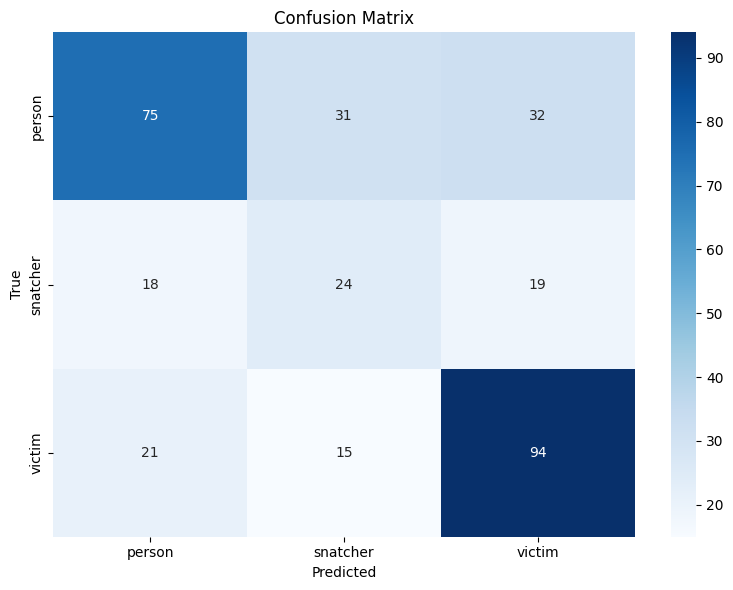

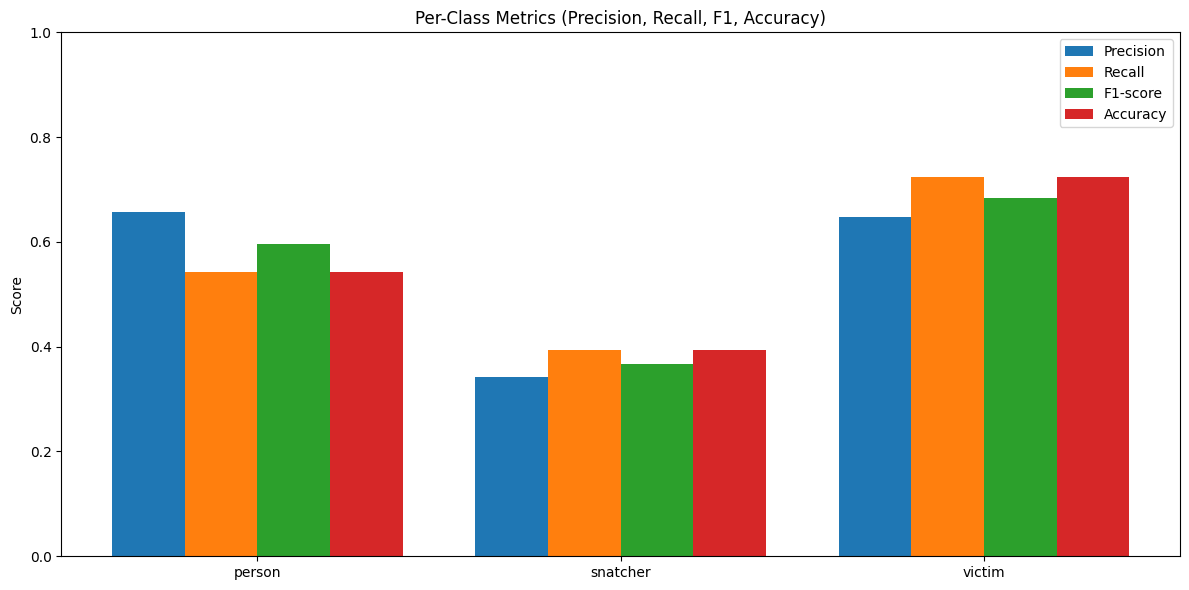

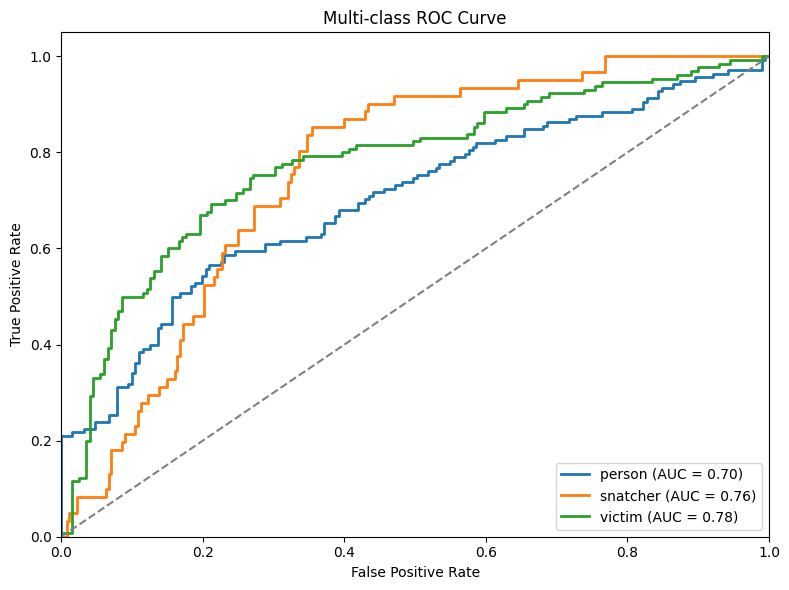

In [41]:
import sys
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
from pytorch_i3d import InceptionI3d
from tqdm import tqdm
import numpy as np

# -------------------------------
# Custom print
# -------------------------------
def custom_print(msg):
    sys.stdout.write(msg + "\n")
    sys.stdout.flush()

# -------------------------------
# Config
# -------------------------------
dataset_path = r"D:\I3D\yashti_test\Merged dataset"
model_path = r"D:\I3D\MODEL\i3d_finetuned.pt"
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_print(f"Using device: {device}")

# -------------------------------
# Dataset class
# -------------------------------
class VideoClipDataset(torch.utils.data.Dataset):
    def __init__(self, data_root):
        self.clip_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(data_root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}
        custom_print(f"📁 Found classes: {self.class_names}")

        for cls in self.class_names:
            folder = os.path.join(data_root, cls)
            for f in os.listdir(folder):
                if f.endswith(".pt"):
                    self.clip_paths.append(os.path.join(folder, f))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.clip_paths)

    def __getitem__(self, idx):
        clip = torch.load(self.clip_paths[idx], map_location="cpu").float()
        label = self.labels[idx]
        return clip, label

# -------------------------------
# Load dataset and DataLoader
# -------------------------------
dataset = VideoClipDataset(dataset_path)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
num_classes = len(dataset.class_names)
custom_print(f"Total clips: {len(dataset)} | Classes: {num_classes}")

# -------------------------------
# Load model
# -------------------------------
i3d = InceptionI3d(400, in_channels=32)
i3d.replace_logits(num_classes)
i3d.avg_pool = nn.AvgPool3d(kernel_size=(1, 7, 7), stride=1, padding=(0, 0, 0))
i3d = i3d.to(device)

state_dict = torch.load(model_path, map_location=device)
i3d.load_state_dict(state_dict)
i3d.eval()
custom_print(f"Model loaded from {model_path}")

# -------------------------------
# Evaluation
# -------------------------------
criterion = nn.CrossEntropyLoss()
all_preds, all_labels, all_probs = [], [], []

custom_print("📊 Starting evaluation...")
progress_bar = tqdm(loader, desc="Evaluating", ncols=90)

with torch.no_grad():
    for clips, labels in progress_bar:
        clips, labels = clips.to(device), labels.to(device)
        outputs = i3d(clips)
        outputs = outputs.squeeze(-1).squeeze(-1).squeeze(-1)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=dataset.class_names, zero_division=0, output_dict=True)
cm = confusion_matrix(all_labels, all_preds)

custom_print(f"✅ Accuracy: {accuracy*100:.2f}%")
custom_print("📊 Classification Report:")
for cls, metrics in report.items():
    if cls not in ['accuracy', 'macro avg', 'weighted avg']:
        custom_print(f"{cls}: Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1: {metrics['f1-score']:.2f}")

# -------------------------------
# Confusion Matrix
# -------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.class_names, yticklabels=dataset.class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("i3d_confusion_matrix.png")
custom_print("📈 Confusion matrix saved as i3d_confusion_matrix.png")

# -------------------------------
# Metrics Barplot (Precision, Recall, F1)
# -------------------------------
metrics_names = ['precision', 'recall', 'f1-score', 'accuracy']
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(dataset.class_names))

# Prepare values
precision_vals = [report[cls]['precision'] for cls in dataset.class_names]
recall_vals = [report[cls]['recall'] for cls in dataset.class_names]
f1_vals = [report[cls]['f1-score'] for cls in dataset.class_names]
accuracy_vals = [(cm[i, i]/cm[i].sum()) if cm[i].sum()>0 else 0 for i in range(len(dataset.class_names))]  # per-class accuracy

for i, (metric_name, values) in enumerate(zip(metrics_names, [precision_vals, recall_vals, f1_vals, accuracy_vals])):
    plt.bar(index + i*bar_width, values, bar_width, label=metric_name.capitalize())

plt.xticks(index + 1.5*bar_width, dataset.class_names)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Per-Class Metrics (Precision, Recall, F1, Accuracy)")
plt.legend()
plt.tight_layout()
plt.savefig("i3d_metrics_barplot_with_accuracy.png")
custom_print("📊 Metrics barplot with accuracy saved as i3d_metrics_barplot_with_accuracy.png")

# -------------------------------
# Multi-class ROC AUC Curve
# -------------------------------
all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
all_probs_np = np.array(all_probs)

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs_np[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{dataset.class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("i3d_roc_auc_curve.png")
custom_print("📈 ROC AUC curve saved as i3d_roc_auc_curve.png")
